In [1]:
 ! pip install -q kaggle

In [6]:
!kaggle competitions download -c dogs-vs-cats

 98% 792M/812M [00:03<00:00, 241MB/s]
100% 812M/812M [00:03<00:00, 221MB/s]


In [9]:
import pathlib
DataPath = pathlib.Path('train')

In [21]:
all_paths = DataPath.glob('*.jpg')
all_paths

<generator object Path.glob at 0x7f136f269e50>

In [22]:
all_paths = list(all_paths)
all_paths[:10]

[PosixPath('train/cat.15.jpg'),
 PosixPath('train/dog.329.jpg'),
 PosixPath('train/cat.9268.jpg'),
 PosixPath('train/cat.9220.jpg'),
 PosixPath('train/cat.1924.jpg'),
 PosixPath('train/dog.4585.jpg'),
 PosixPath('train/cat.3830.jpg'),
 PosixPath('train/dog.4039.jpg'),
 PosixPath('train/dog.1461.jpg'),
 PosixPath('train/dog.4930.jpg')]

In [23]:
all_paths = [str(x) for x in all_paths]

In [24]:
import tensorflow as tf

In [25]:

def testimagequality(all_paths):
  new_all_path = []
  for path in all_paths:
    try:
      image = tf.io.read_file(path)
      image = tf.io.decode_jpeg(image, channels = 3)
    except:
      continue
    new_all_path.append(path)
  return new_all_path

all_paths = testimagequality(all_paths)
all_paths[:10]

['train/cat.15.jpg',
 'train/dog.329.jpg',
 'train/cat.9268.jpg',
 'train/cat.9220.jpg',
 'train/cat.1924.jpg',
 'train/dog.4585.jpg',
 'train/cat.3830.jpg',
 'train/dog.4039.jpg',
 'train/dog.1461.jpg',
 'train/dog.4930.jpg']

In [26]:

def get_label(image_path):
  return image_path.split('/')[-2]

all_labels = list(map(lambda x : get_label(x), all_paths))
all_labels[:10]

['train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train']

In [27]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
all_labels = le.fit_transform(all_labels)

In [28]:
# splitting the dataset in to training and validation part
from sklearn.model_selection import train_test_split
train_path, val_path, train_label, val_label = train_test_split(all_paths, all_labels)

In [29]:
# function to load the image in form of tensors

def load(image, label):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image, channels = 3)
  return image, label

In [30]:

# defining the data augumentation for the image
img_size = 224
batch_size = 128

# basic transformation
resize = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.Resizing(img_size, img_size)
])

# data augumentation
data_augumentation = tf.keras.Sequential([
                        tf.keras.layers.RandomFlip('horizontal'),
                        tf.keras.layers.RandomRotation(0.2),
                        tf.keras.layers.RandomZoom(height_factor = (-0.3,-0.2))])


In [31]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def get_dataset(path, label, train = True):
  image_paths = tf.convert_to_tensor(path)  # took the image paths and converted to tensors
  labels = tf.convert_to_tensor(label)      # took the labels and converted to tensors

  image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)    # created a  dataset from the image path tensors
  label_dataset = tf.data.Dataset.from_tensor_slices(labels)         # created a dataset from the labels tensors
  dataset = tf.data.Dataset.zip((image_dataset, label_dataset))      # zipped the complete dataset

  dataset = dataset.map(lambda image, label : load(image, label))    # load the image using the function we have already created
  dataset = dataset.map(lambda image, label: (resize(image), label), num_parallel_calls = AUTOTUNE) # resizing the image using the pipeline we have specified
  dataset = dataset.shuffle(1000)    # shuffling idk
  dataset = dataset.batch(batch_size) # the complete batch of the dataset

  # we will be augumenting the data only in case its the training data and not for validation data

  if train:
    dataset = dataset.map(lambda image, label: (data_augumentation(image), label), num_parallel_calls = AUTOTUNE) # data augumentation
    dataset = dataset.repeat()
  return dataset

In [32]:
# create train dataset object and veryfying it
train_dataset = get_dataset(train_path, train_label)
val_dataset = get_dataset(val_path, val_label)
image, label = next(iter(train_dataset))

print(image.shape)
print(label.shape)

(128, 224, 224, 3)
(128,)


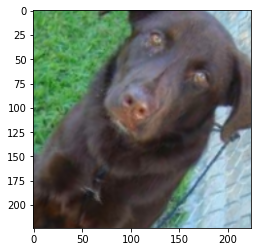

In [33]:
import matplotlib.pyplot as plt
plt.imshow((image[1].numpy()/255).reshape(224,224,3))

In [35]:
# building resnet 50 model
from tensorflow.keras.applications import ResNet50V2

In [37]:
backbone = ResNet50V2(input_shape = (224,224,3), 
                      include_top = False)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')])


In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


In [39]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
history = model.fit(
    train_dataset,
    steps_per_epoch = len(train_path)//batch_size,
    epochs = 10,
    validation_data = val_dataset,
    validation_steps = len(val_path)//batch_size)

Epoch 1/10
146/146 [==============================] - 11956s 82s/step - loss: 0.0054 - accuracy: 0.9969 - val_loss: 1.9047e-09 - val_accuracy: 1.0000
Epoch 2/10
146/146 [==============================] - ETA: 0s - loss: 3.0186e-06 - accuracy: 1.0000  